# Image Classification using Convolutional Neural Networks in PyTorch

이 시리즈의 다섯번째 파트에서는 다음과 같은 항목을 다룹니다.

* 웹 URL에서 이미지 데이터 세트 다운로드
* 컨볼루션 및 풀링 계층 이해
* PyTorch를 사용한 컨볼루션 신경망(CNN) 생성
* CNN 학습 및 성능 모니터링
* 언더피팅, 오버피팅 및 이를 해결하는 방법

## Exploring the CIFAR10 Dataset

이전 튜토리얼에서 우리는 MNIST 데이터 세트의 손으로 쓴 숫자를 97% 이상의 정확도로 분류하기 위해 단일 히든 레이어가 있는 feed-forward 신경망을 훈련했습니다. 이 자습서에서는 10개의 클래스에 60000개의 32x32픽셀 컬러 이미지로 구성된 CIFAR10 데이터 세트를 사용합니다. 다음은 데이터 세트의 샘플 이미지입니다.

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

torchvision 및 tarfile 패키지의 일부 도우미 함수를 사용하여 이 페이지에서 PNG 형식의 이미지를 다운로드합니다.

In [3]:
# 데이터셋 url로 다운로드
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, 'data/')

0it [00:00, ?it/s]

In [2]:
# tarfile 모듈을 사용하면 gzip, bz2 및 lzma 압축을 사용하는 것을 포함하여, tar 아카이브를 읽고 쓸 수 있습니다.
# r:gz : gzip 압축 파일을 읽기 위해 엽니다.
with tarfile.open('data/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='data/')

데이터 세트는 data/cifar10 디렉토리에 추출됩니다. 여기에는 훈련 세트(50000개 이미지)와 테스트 세트(10000개 이미지)를 각각 포함하는 'train' 및 'test' 폴더 2개가 포함되어 있습니다. 각각은 이미지의 각 클래스에 대해 하나씩 10개의 폴더를 포함합니다. os.listdir을 사용하여 이것을 확인합시다.

In [3]:
data_dir = 'data/cifar10'
print(os.listdir(data_dir))

classes = data_dir + '/train'
print(os.listdir(classes))

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


두 개의 폴더 내부를 살펴보겠습니다. 하나는 훈련 세트에서, 다른 하나는 테스트 세트에서 가져옵니다. 연습으로 각 클래스에 동일한 수의 이미지(트레이닝 세트에 5000개, 테스트 세트에 1000개)가 있는지 확인할 수 있습니다.

In [4]:
airplane_files = os.listdir(classes + '/airplane')
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [5]:
ship_test_files = os.listdir(data_dir + '/test/ship')
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


위의 디렉토리 구조(클래스당 하나의 폴더)는 많은 컴퓨터 비전 데이터 세트에서 사용되며 대부분의 딥 러닝 라이브러리는 이러한 데이터 세트 작업을 위한 유틸리티를 제공합니다. 데이터를 PyTorch 텐서로 로드하기 위해 torchvision의 ImageFolder 클래스를 사용할 수 있습니다.

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(classes, transform=ToTensor())

훈련 데이터 세트의 샘플 요소를 살펴보겠습니다. 각 요소는 이미지 텐서와 레이블을 포함하는 튜플입니다. 데이터는 3채널(RGB)의 32x32픽셀 컬러 이미지로 구성되어 있으므로 각 이미지 텐서의 모양은 (3, 32, 32)입니다.

In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

클래스 목록은 데이터세트의 .classes 속성에 저장됩니다. 각 요소의 숫자 레이블은 클래스 목록에서 요소 레이블의 인덱스에 해당합니다.

In [8]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


matplotlib를 사용하여 이미지를 볼 수 있지만 텐서 차원을 (32,32,3)로 변경해야 합니다. 이미지와 레이블을 표시하는 도우미 함수를 만들어 봅시다.

In [9]:
import matplotlib
import matplotlib.pyplot as plt

# %matplotlib inline 명령어를 사용하면 플로팅 명령의 출력이 Jupyter Notebook과 같은 프론트에서 실행하면 결과를 셀 아래 inline으로 표시
%matplotlib inline

In [10]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

데이터 세트에서 몇 가지 이미지를 살펴보겠습니다. 알 수 있듯이 32x32px 이미지는 사람의 눈으로도 식별하기가 매우 어렵습니다. 다른 이미지를 보려면 아래 인덱스를 변경해 보세요.

Label:  airplane (0)


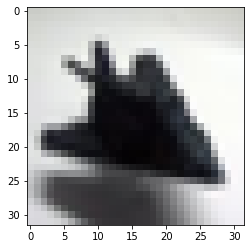

In [11]:
show_example(*dataset[0])

Label:  airplane (0)


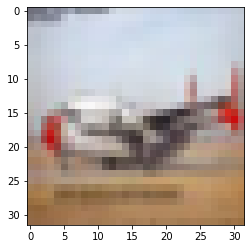

In [12]:
show_example(*dataset[1099])

----------------------------------------------------------------------------------------------------------------------------------------

## Training and Validation Datasets

실제 기계 학습 모델을 구축하는 동안 데이터 세트를 세 부분으로 나누는 것이 일반적입니다.

* 트레이닝 세트 - 모델을 트레이닝하는 데 사용됩니다. 즉, 경사 하강법을 사용하여 손실을 계산하고 모델의 가중치를 조정합니다.
* 검증 세트 - 훈련하는 동안 모델을 평가하고 하이퍼파라미터(학습률 등)를 조정하고 모델의 최상의 버전을 선택하는 데 사용됩니다.
* 테스트 세트 - 다양한 모델 또는 다양한 유형의 모델링 접근 방식을 비교하고 모델의 최종 정확도를 보고하는 데 사용됩니다.

미리 정의된 유효성 검사 세트가 없기 때문에 유효성 검사 세트로 사용할 교육 세트의 작은 부분(5000개 이미지)을 별도로 설정할 수 있습니다. 이를 위해 PyTorch의 random_split 도우미 메서드를 사용합니다. 항상 동일한 검증 세트를 생성하기 위해 난수 생성기에 대한 시드도 설정합니다.

In [13]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

이제 훈련 및 검증을 위한 데이터 로더를 생성하여 데이터를 배치로 로드할 수 있습니다.

In [14]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

torchvision의 make_grid 메서드를 사용하여 데이터 세트에서 이미지 배치를 볼 수 있습니다. 샘플러가 배치를 생성하기 전에 인덱스를 섞기 때문에 다음 코드가 실행될 때마다 다른 바흐를 얻습니다.

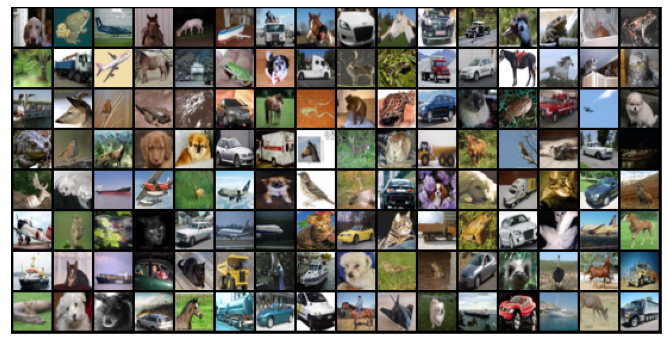

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, _ in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_dl)

----------------------------------------------------------------------------------------------------------------------------------------

## Defining the Model (Convolutional Neural Network)

이전 튜토리얼에서 nn.Linear를 사용하여 완전히 연결된 레이어가 있는 심층 신경망을 정의했습니다. 그러나 이 자습서에서는 PyTorch의 nn.Conv2d 클래스를 사용하여 컨벌루션 신경망을 사용합니다.

2D 컨볼루션은 본질적으로 매우 간단한 작업입니다. 단순히 가중치의 작은 행렬인 커널로 시작합니다. 이 커널은 2D 입력 데이터 위로 "슬라이드"하여 현재 있는 입력 부분과 요소별 곱셈을 수행한 다음 결과를 단일 출력 픽셀로 합산합니다. 


<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">

[출처] https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

3x3 커널을 사용하여 1채널 이미지에서 컨볼루션 작업을 구현해 보겠습니다.

In [65]:
# Pytorch
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [66]:
# Numpy
sample_image = np.array([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
])

sample_kernel = np.array([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
])

def apply_kernel_np(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = np.zeros((ro, co))
    
    for i in range(ro):
        for j in range(co):
            output[i, j] = np.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

apply_kernel_np(sample_image, sample_kernel)

array([[12., 12., 17.],
       [10., 17., 19.],
       [ 9.,  6., 14.]])

In [67]:
# Python list
sample_image = [
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
]

sample_kernel = [
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
]

def apply_kernel_py(image, kernel):
    ri, ci = len(image), len(image[0])
    rk, ck = len(kernel), len(kernel[0])
    ro, co = ri-rk+1, ci-ck+1
    output = [[0 for i in range(ro)] for j in range(co)]
    
    for x in range(ro):
        for y in range(co):
            for i in range(ro):
                for j in range(co):
                    output[x][y] += image[x+i][y+j] * kernel[i][j]
    return output

apply_kernel_py(sample_image, sample_kernel)

[[12, 12, 17], [10, 17, 19], [9, 6, 14]]

----------------------------------------------------------------------------------------------------------------------------------------

다중 채널 이미지의 경우 각 채널에 다른 커널이 적용되고 출력이 픽셀 단위로 함께 추가됩니다.

이미지 데이터로 작업할 때 컨볼루션 레이어가 제공하는 특정 이점이 있습니다.

* 더 적은 매개변수: 전체 이미지의 출력을 계산하는 데 작은 매개변수 세트(커널)가 사용되므로 완전 연결된 계층에 비해 모델의 매개변수가 훨씬 적습니다.
* 연결 희소성: 각 레이어에서 각 출력 요소는 적은 수의 입력 요소에만 의존하므로 정방향 및 역방향 전달이 더 효율적입니다.
* 매개변수 공유 및 공간 불변성: 이미지의 한 부분에서 커널이 학습한 기능을 사용하여 다른 이미지의 다른 부분에서 유사한 패턴을 감지할 수 있습니다.

또한 max-pooling 레이어를 사용하여 각 컨볼루션 레이어에서 출력 텐서의 높이와 너비를 점진적으로 줄입니다.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

전체 모델을 정의하기 전에 단일 컨볼루션 레이어와 최대 풀링 레이어가 데이터에서 어떻게 작동하는지 살펴보겠습니다.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [17]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


Conv2d 레이어는 3채널 이미지를 16채널 feature map으로 변환하고 MaxPool2d 레이어는 높이와 너비를 절반으로 줄입니다. 피처 맵은 더 많은 레이어를 추가함에 따라 점점 작아지고 마침내 벡터로 평면화할 수 있는 작은 피처 맵이 남게 됩니다. 그런 다음 끝에 완전히 연결된 레이어를 추가하여 각 이미지에 대해 크기 10의 벡터를 얻을 수 있습니다.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

학습 및 검증을 위한 도우미 메서드가 포함된 `ImageClassificationBase` 클래스를 확장하여 모델을 정의해 보겠습니다.

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

우리는 nn.Sequential을 사용하여 레이어와 활성화 기능을 단일 네트워크 아키텍처로 연결합니다.

In [19]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [20]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

모델이 훈련 데이터 배치에서 예상 출력을 생성하는지 확인해 보겠습니다. 각 이미지에 대한 10개의 출력은 (softmax를 적용한 후) 10개의 대상 클래스에 대한 확률로 해석될 수 있으며 확률이 가장 높은 클래스가 입력 이미지에 대한 모델에 의해 예측된 레이블로 선택됩니다. 3부(로지스틱 회귀)에서 출력 인터페팅, softmax 적용 및 예측 레이블 식별에 대한 자세한 내용을 확인하세요.

In [21]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0227,  0.0050,  0.0075, -0.0167,  0.0360, -0.0371, -0.0080, -0.0307,
        -0.0291,  0.0121], grad_fn=<SelectBackward>)


GPU를 원활하게 사용하기 위해 사용 가능한 경우 몇 가지 도우미 함수(get_default_device 및 to_device)와 도우미 클래스 DeviceDataLoader를 정의하여 필요에 따라 모델 및 데이터를 GPU로 이동합니다. 이전 자습서에 자세히 설명되어 있습니다.

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

이 노트북을 실행하는 위치에 따라 기본 장치는 CPU(torch.device('cpu')) 또는 GPU(torch.device('cuda'))일 수 있습니다.

In [23]:
device = get_default_device()
device

device(type='cuda')

이제 데이터 배치를 GPU(사용 가능한 경우)로 자동 전송하기 위해 'DeviceDataLoader'를 사용하여 교육 및 검증 데이터 로더를 래핑하고(사용 가능한 경우) 모델을 GPU로 이동하기 위해 'to_device'를 사용할 수 있습니다.

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

----------------------------------------------------------------------------------------------------------------------------------------

## Training the Model

기울기 하강법을 사용하여 모델을 훈련하고 유효성 검사 세트에서 성능을 평가하기 위해 fit 및 evaluate의 두 가지 함수를 정의합니다. 이러한 기능에 대한 자세한 연습은 이전 자습서를 확인하세요.

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

학습을 시작하기 전에 모델을 다시 한 번 인스턴스화하고 초기 매개변수 세트를 사용하여 검증 세트에서 어떻게 수행되는지 살펴보겠습니다.

In [26]:
model = to_device(Cifar10CnnModel(), device)

In [27]:
evaluate(model, val_dl)

{'val_loss': 2.3031396865844727, 'val_acc': 0.10143611580133438}

초기 정확도는 약 10%이며, 이는 임의로 초기화된 모델에서 예상할 수 있는 것입니다(무작위로 추측하여 레이블을 올바르게 얻을 확률이 1/10이므로).

모델을 훈련하기 위해 다음 하이퍼파라미터(학습률, 에포크 수, batch_size 등)를 사용할 것입니다. 연습으로 이것을 변경하여 더 짧은 시간에 더 높은 정확도를 달성했는지 확인할 수 있습니다.

In [28]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [29]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8499, val_loss: 1.5837, val_acc: 0.3991
Epoch [1], train_loss: 1.3390, val_loss: 1.1821, val_acc: 0.5629
Epoch [2], train_loss: 1.0611, val_loss: 1.0078, val_acc: 0.6312
Epoch [3], train_loss: 0.8587, val_loss: 0.8493, val_acc: 0.7036
Epoch [4], train_loss: 0.7211, val_loss: 0.7684, val_acc: 0.7308
Epoch [5], train_loss: 0.6157, val_loss: 0.7176, val_acc: 0.7577
Epoch [6], train_loss: 0.5212, val_loss: 0.7407, val_acc: 0.7515
Epoch [7], train_loss: 0.4492, val_loss: 0.7458, val_acc: 0.7534
Epoch [8], train_loss: 0.3827, val_loss: 0.7483, val_acc: 0.7640
Epoch [9], train_loss: 0.3105, val_loss: 0.7411, val_acc: 0.7759


유효성 검사 세트 정확도를 플롯하여 시간이 지남에 따라 모델이 어떻게 개선되는지 연구할 수 있습니다.

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

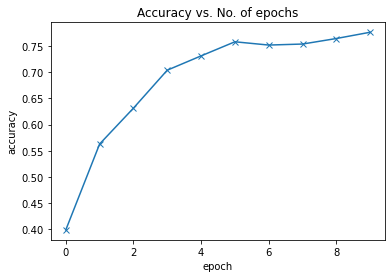

In [31]:
plot_accuracies(history)

우리 모델은 약 75%의 정확도에 도달하는데, 그래프를 보면 오랜 시간 훈련을 해도 모델이 80% 이상의 정확도를 달성할 가능성은 없어 보입니다. 이는 이미지와 라벨 간의 관계를 보다 정확하게 캡처하기 위해 보다 강력한 모델을 사용해야 할 수도 있음을 시사합니다. 이는 모델에 더 많은 컨볼루션 레이어를 추가하거나 no. 각 컨볼루션 레이어의 채널 수 또는 정규화 기술을 사용하여.

추세를 연구하기 위해 훈련 및 검증 손실을 플롯할 수도 있습니다.

In [32]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

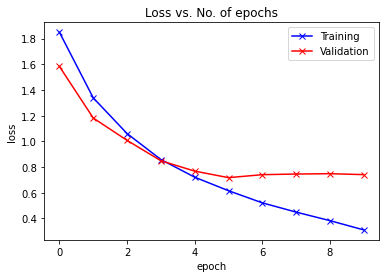

In [33]:
plot_losses(history)

처음에는 훈련 및 검증 손실이 모두 시간이 지남에 따라 감소하는 것으로 보입니다. 그러나 모델을 충분히 오래 훈련하면 훈련 손실이 계속 감소하는 반면 유효성 검사 손실은 감소를 멈추고 특정 시점 이후에는 증가하기 시작합니다!

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

이 현상을 과대적합이라고 하며, 이것이 아닙니다. 1 많은 기계 학습 모델이 실제 데이터에 대해 다소 끔찍한 결과를 제공하는 이유. 모델이 손실을 최소화하기 위해 학습 데이터에 고유한 패턴을 학습하기 시작하고 때로는 특정 학습 예제를 기억하기 때문에 발생합니다. 이 때문에 모델은 이전에 본 적이 없는 데이터로 잘 일반화되지 않습니다.

다음은 과적합을 방지하기 위한 몇 가지 일반적인 전략입니다.

* 더 많은 교육 데이터를 수집 및 생성하거나 여기에 노이즈 추가
* 배치 정규화 및 드롭아웃과 같은 정규화 기술 사용
* 유효성 검사 손실이 증가하기 시작하면 모델 교육을 조기에 중지합니다.

이 시리즈의 다음 자습서에서 이러한 주제를 자세히 다루고 모델에 사소하지만 중요한 변경을 수행하여 90% 이상의 정확도에 도달하는 방법을 알아봅니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Testing with individual images

지금까지 모델의 전반적인 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 살펴보는 것도 좋은 생각입니다. 미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보겠습니다. ImageFolder 클래스를 사용하여 테스트 데이터 세트를 만드는 것으로 시작합니다.

In [34]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

단일 이미지 텐서에 대한 예측 레이블을 반환하는 도우미 함수 predict_image를 정의해 보겠습니다.

In [35]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


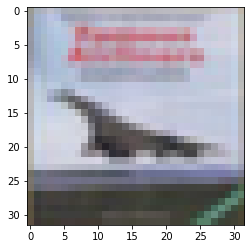

In [36]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


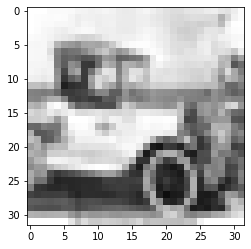

In [37]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


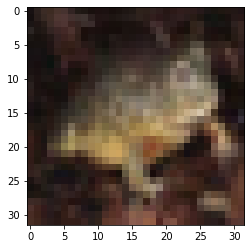

In [38]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

모델이 제대로 작동하지 않는 부분을 식별하면 더 많은 교육 데이터를 수집하고 모델의 복잡성을 늘리거나 줄이며 하이퍼파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있습니다.

마지막 단계로 테스트 세트에서 모델의 전반적인 손실과 정확도를 살펴보고 jovian을 사용하여 기록해 보겠습니다. 이러한 값은 유효성 검사 세트의 값과 비슷할 것으로 예상됩니다. 그렇지 않은 경우 테스트 세트(종종 실제 데이터에서 가져옴)와 유사한 데이터 및 분포를 가진 더 나은 유효성 검사 세트가 필요할 수 있습니다.

In [39]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.7813739776611328, 'val_acc': 0.77001953125}

----------------------------------------------------------------------------------------------------------------------------------------

## Saving and loading the modeltorch.save(model.state_dict(), 'cifar10-cnn.pth')

우리는 오랜 시간 동안 모델을 훈련시켰고 합리적인 정확도를 달성했기 때문에 나중에 모델을 재사용하고 처음부터 다시 훈련하지 않도록 모델의 가중치를 디스크에 저장하는 것이 좋습니다. 모델을 저장하는 방법은 다음과 같습니다.

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

.state_dict 메서드는 모델의 올바른 속성에 매핑된 모든 가중치 및 편향 행렬을 포함하는 OrderedDict를 반환합니다. 모델 가중치를 로드하기 위해 동일한 구조로 모델을 재정의하고 .load_state_dict 메서드를 사용할 수 있습니다.

In [ ]:
model2 = to_device(Cifar10CnnModel(), device)

model2.load_state_dict(torch.load('cifar10-cnn.pth'))

온전한 검사로 이 모델이 테스트 세트에서 이전과 동일한 손실 및 정확도를 갖는지 확인합시다.

In [ ]:
evaluate(model2, test_loader)